In [1]:
import sys
from pathlib import Path
import functools

import mujoco
from brax import envs
import jax
import jax.numpy as jp

from envs import register_framed_hopper
from shac.brax_wrappers import AppendObsHistory

import shac.networks as shac_networks
# import shac.train as  shac
from shac.train import SHAC

In [2]:
env_name = 'framed_hopper'

log_sigma = None
make_networks_factory = functools.partial(
    shac_networks.make_shac_networks,
        policy_hidden_layer_sizes=(64, 64),
        value_hidden_layer_sizes =(64, 64),
        scalar_var=False,
        layer_norm=True)

In [3]:
# Parameters
num_epochs = 200
num_evals = num_epochs + 1

unroll_length = 32

num_envs = 64

num_timesteps = (num_envs*unroll_length)*num_epochs

num_critic_minibatches = 4
num_critic_data = num_envs*unroll_length
critic_batch_size = num_critic_data / num_critic_minibatches

episode_length = 240 

# Logging
num_grad_checks = None
save_all_policy_gradients = True

# Env parameters
action_pad = 1e-2

In [4]:
env      = AppendObsHistory(envs.get_environment(env_name, action_pad=action_pad), h=3)
eval_env = AppendObsHistory(envs.get_environment(env_name, action_pad=action_pad), h=3)
# env = envs.get_environment(env_name)
# eval_env = envs.get_environment(env_name)

In [5]:
kwargs = dict(
  num_timesteps=num_timesteps, log_sigma=log_sigma,
  num_evals=num_evals, use_tbx=True, tbx_logdir=f'{env_name}_log',
  tbx_experiment_name="obs_hist_wrapped", reward_scaling=1, 
  num_eval_envs = 64, num_envs=num_envs,
  unroll_length=unroll_length, critic_batch_size=critic_batch_size,
  critic_epochs = 16,target_critic_alpha = 0.2,
  discounting = 0.99, lambda_ = 0.95,
  normalize_observations=True,
  episode_length=episode_length, 
  network_factory = make_networks_factory, 
  seed=10, entropy_cost = 1e-3,
  resample_init=True,
  scramble_initial_times=True,
  num_grad_checks=num_grad_checks,
  save_all_checkpoints=True,
  save_all_policy_gradients=save_all_policy_gradients
)

trainer = SHAC(environment=env, eval_env=eval_env, **kwargs)

Env steps per training step: 2048
Training steps per epoch: 1
Critic minibatches per critic epoch: 4


In [9]:
make_inference_fn, policy_params, value_params, _= trainer.train()


Initial eval time: 8.7690 s
Deleting old checkpoints!
Checkpointed for epoch 0
Checkpointed for epoch 1
Checkpointed for epoch 2
Checkpointed for epoch 3
Checkpointed for epoch 4
Checkpointed for epoch 5
Checkpointed for epoch 6
Checkpointed for epoch 7
Checkpointed for epoch 8
Checkpointed for epoch 9
Checkpointed for epoch 10
Checkpointed for epoch 11
Checkpointed for epoch 12
Checkpointed for epoch 13
Checkpointed for epoch 14
Checkpointed for epoch 15
Checkpointed for epoch 16
Checkpointed for epoch 17
Checkpointed for epoch 18
Checkpointed for epoch 19
Checkpointed for epoch 20
Checkpointed for epoch 21
Checkpointed for epoch 22
Checkpointed for epoch 23
Checkpointed for epoch 24
Checkpointed for epoch 25
Checkpointed for epoch 26


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 27


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 28


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 29


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 30


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 31


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 32


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 33


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 34


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 35


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 36


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 37


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 38


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 39


at mapped index 0: Gradient ~ 0! (`check` failed)
Checkpointed for epoch 40


KeyboardInterrupt: 

#### Eval

In [ ]:
# utils_path = Path(Path.cwd().parent,
#                   Path("benchmarks"),
#                   Path("quadruped_stability_studies"))
# sys.path.append(str(utils_path))

from jax_shac.utils.eval_utils import plot_jacobian_norms, visualize_rollout, plot_rews

In [ ]:
renderer = mujoco.Renderer(env.model)

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(policy_params))

rng = jax.random.key(141)
init_key, rollout_key, rng = jax.random.split(rng, 3)
s0 = jit_reset(init_key)

jit_inference_fn = jax.jit(make_inference_fn(policy_params))

In [ ]:
if False:
    def spoof_policy(_, rng):
        bb = jax.random.choice(rng, jp.array([-1, 1]), 
                            p=jp.array([0.9, 1]))
        return bb.reshape(1), {}
        # return 2*(jax.random.uniform(rng).reshape(1)-0.5), {}
    jit_inference_fn = jax.jit(spoof_policy)

<Figure size 640x480 with 0 Axes>

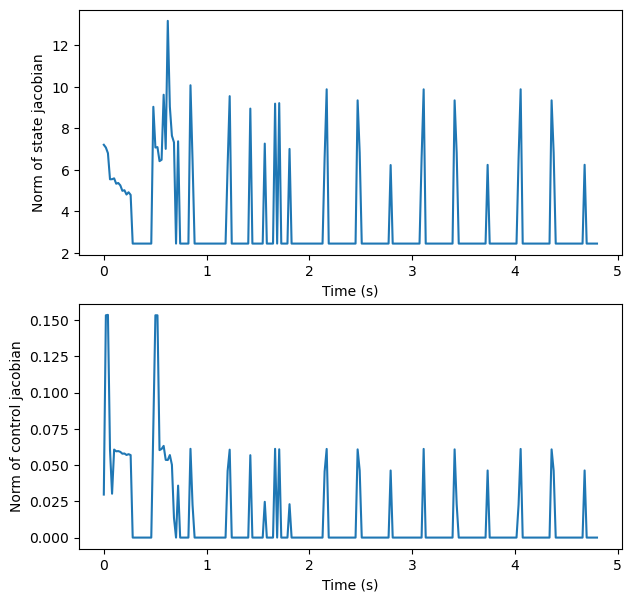

In [ ]:
if True:
    """ 
    Nan gradients:
    - Not seen in forward-mode AD
    - Jacrev doesn't work
    - Unclear whether nan's in training come from user code or MJX
        - https://github.com/google-deepmind/mujoco/issues/1349
    """
    all_jacs, state_jacs, ctrl_jacs = plot_jacobian_norms(s0, rollout_key, env, jit_inference_fn,
                                                jit_step, episode_length=240,
                                                ret_jacs=True, jacmode='fwd')

In [ ]:
state_h, states = visualize_rollout(s0, rollout_key, env, 
                                    jit_inference_fn, jit_step, renderer, 
                                    episode_length=240, print_nans=False, 
                                    print_dones=True, ret_states=True, camera="track")

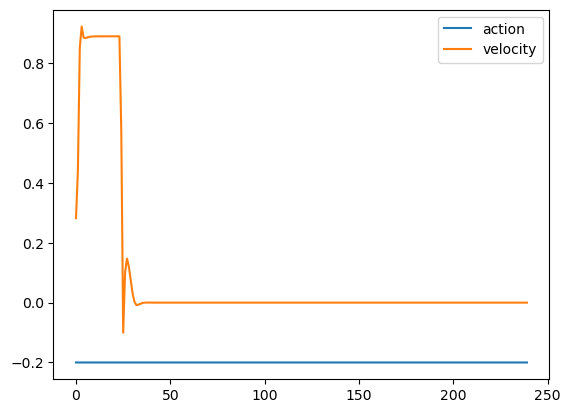

In [ ]:
rews = plot_rews(states)

## Debugging the Nans

Below experiment run with: 
- action_pad = 0
- target_critic_alpha = 0.2

#### Distribution of Nans in the policy gradient

Text(0, 0.5, 'Number of nan gradients')

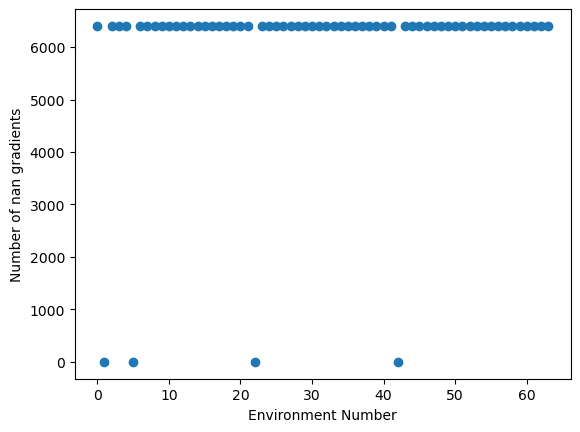

In [52]:
import matplotlib.pyplot as plt
import jax.numpy as jp
import pickle
import jax
import operator

it = 24
# Load policy gradients
bgrad_path = f"/home/andrew/Documents/thesis/jax_shac/shac/policy_gradients/bgrad_{it}.pkl" # TODO
bgrad = pickle.load(open(bgrad_path, "rb"))

# Count the # nans across env axis
app_nan = jax.tree_util.tree_map(lambda l: jp.isnan(l), bgrad)
reduced_leaves = jax.tree_util.tree_map(lambda l: jp.sum(l, axis=(range(1, len(l.shape)))), app_nan)
nans_per_env = jax.tree.reduce(operator.add, reduced_leaves)
# nan_mask = jnp.isnan(bgrad)
# nans_per_env = jnp.sum(nan_mask, axis=0)
# # Plot
num_envs = 64

plt.scatter(jp.linspace(0, num_envs-1, num_envs), nans_per_env)
plt.xlabel("Environment Number")
plt.ylabel("Number of nan gradients")

#### Correspondence between an environment having nan policy gradient, and it having at least one nan mjx jacobian

Conclusion:
- Having at least one nan in a state jacobian is sufficient to cause a nan policy gradient
- There are other causes of nan policy gradients

In [53]:
# Collect a jacobian rollout (13 sec first run)

algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, ts.normalizer_params,
                           state, key)
actions = extras["action"]
print(jacs.shape)

(64, 32, 6, 7)


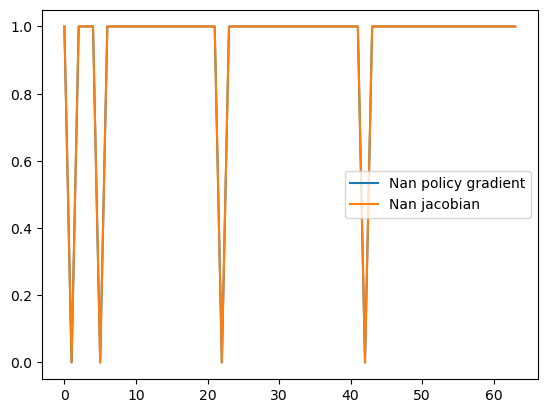

In [54]:
pg_nan_mask = nans_per_env > 0

# See which envs had at least one nan.
jacs_nan_mask = jp.sum(jp.isnan(jacs), axis=(1,2,3))
jacs_nan_mask = jacs_nan_mask > 0

x_axis = jp.linspace(0, 63, 64)

plt.plot(pg_nan_mask, label="Nan policy gradient")
plt.plot(jacs_nan_mask, label="Nan jacobian")
plt.legend()

Text(0.5, 0.98, 'Number of Nan Indicies; Brighter is Larger')

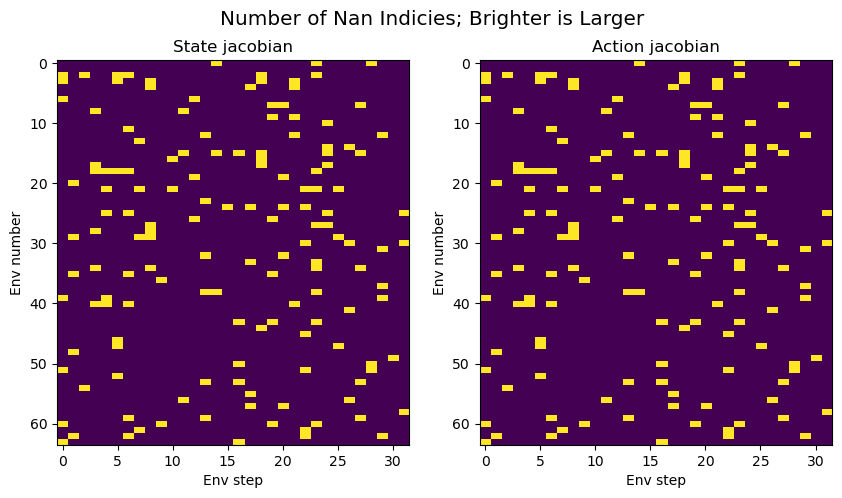

In [55]:
""" 
Take-aways: 
- Either the entire jacobian is nan or none of it.
- Nans are randomly located along the trajectory.
"""

# Where are the nan's happening?
state_dim = env.sys.nq + env.sys.nv
action_dim = env.sys.nu

state_jacs = jacs[..., :state_dim]
action_jacs  = jacs[..., state_dim:state_dim+action_dim]

sjacs_nan_mask = jp.sum(jp.isnan(jacs), axis=(2,3))
ajacs_nan_mask = jp.sum(jp.isnan(jacs), axis=(2,3))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(sjacs_nan_mask, aspect='auto')
axs[1].imshow(ajacs_nan_mask, aspect='auto')
axs[0].set_title("State jacobian")
axs[1].set_title("Action jacobian")
axs[0].set_xlabel("Env step")
axs[0].set_ylabel("Env number")
axs[1].set_xlabel("Env step")
axs[1].set_ylabel("Env number")
# fig.text(0.5, 1, "hi", )
fig.suptitle("Number of Nan Indicies; Brighter is Larger", size='x-large')

Text(0.5, 1.0, 'What are the states and actions resulting in nan jacobians?')

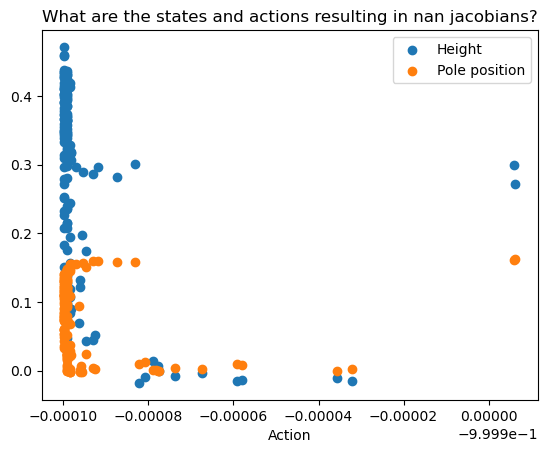

In [56]:
# WLOG
n_actions = actions[sjacs_nan_mask>1]
n_qpos = nstates.pipeline_state.qpos[sjacs_nan_mask>1]

plt.scatter(n_actions, n_qpos[:, 1], label='Height')
plt.scatter(n_actions, n_qpos[:, 2], label="Pole position")
plt.legend()
plt.xlabel("Action")
plt.title("What are the states and actions resulting in nan jacobians?")

In [57]:
sum(n_actions)
# n_actions.shape

Array([-147.99928], dtype=float32)

Text(0.5, 1.0, 'Distribution of actions (envs, time)')

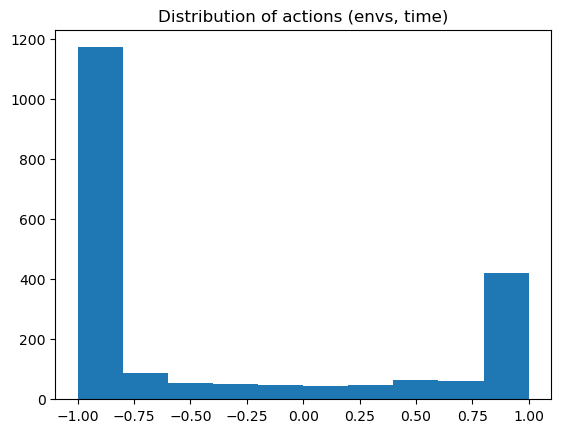

In [39]:
flat_actions = jp.reshape(actions, newshape=(actions.size,))
plt.hist(flat_actions)
plt.title("Distribution of actions (envs, time)")

(array([4., 4., 5., 2., 5., 7., 2., 2., 5., 1.]),
 array([0.54000014, 0.95200282, 1.36400557, 1.77600825, 2.18801093,
        2.60001349, 3.0120163 , 3.42401886, 3.83602166, 4.24802446,
        4.66002703]),
 <BarContainer object of 10 artists>)

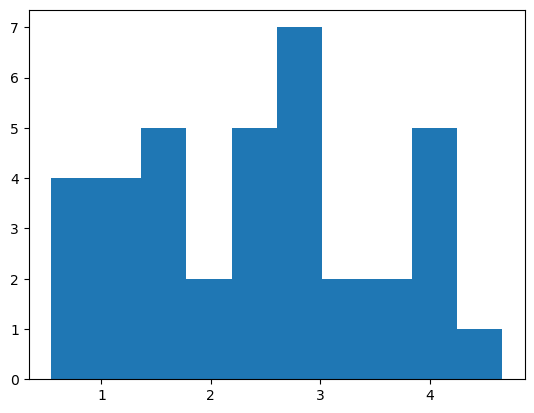

In [36]:
# Does it have to do with time?
plt.hist(nstates.pipeline_state.time[sjacs_nan_mask>1])

In [35]:
nstates.pipeline_state.time

Array([[3.0800319 , 3.1000328 , 3.1200337 , ..., 3.660059  , 3.68006   ,
        3.7000608 ],
       [1.6799855 , 1.6999853 , 1.719985  , ..., 2.2599936 , 2.2799945 ,
        2.2999954 ],
       [3.5200524 , 3.5400534 , 3.5600543 , ..., 4.1000676 , 4.120066  ,
        4.1400647 ],
       ...,
       [1.9799817 , 1.9999814 , 2.0199823 , ..., 2.5600076 , 2.5800085 ,
        2.6000094 ],
       [1.879983  , 1.8999827 , 1.9199824 , ..., 2.460003  , 2.4800038 ,
        2.5000048 ],
       [0.18      , 0.20000005, 0.22000009, ..., 0.7599973 , 0.77999705,
        0.7999968 ]], dtype=float32, weak_type=True)